# ClinvarKO analysis v4
Author: Peter DeWeirdt  
Affiliation: Genetic Perturbation Platform, Broad Institute  
Github: https://github.com/PeterDeWeirdt 

Here we compare the ClinVar library screened with base editor or wildtype Cas9. This analysis is a part of the manuscript "Massively parallel assessment of human variants with base editor screens" by Hanna et al. 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
import re
from scipy import stats
from scipy.interpolate import interpn
import requests
from adjustText import adjust_text
from matplotlib.lines import Line2D


In [2]:
import sys
print('Python version: ' + sys.version)

Python version: 3.8.2 | packaged by conda-forge | (default, Mar  5 2020, 16:54:44) 
[Clang 9.0.1 ]


In [3]:
modules = ['pandas', 'seaborn', 'matplotlib', 'numpy', 're', 'scipy', 'requests', 'adjustText']
for module in modules:
    try:
        print(module + ' ' + sys.modules[module].__version__)
    except:
        print(module + ' has no __version__ attribute')

pandas 1.0.2
seaborn 0.10.0
matplotlib 3.2.1
numpy 1.18.1
re 2.2.1
scipy 1.4.1
requests 2.23.0
adjustText has no __version__ attribute


In [4]:
# helper function for creating figures
# convert tuple of centimeters to inches
def cm2inch(*tupl):
    inch = 2.54
    if isinstance(tupl[0], tuple):
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)
    
def point_density_plot(x_col, y_col, data = None, bins = [20,20], pearson=True, **kwargs): 
    """Scatter plot with points colored by density
    
    Rasterized scatterplot for easy illustrator import
    Args:
        x: what to plot on the x axis
        y: what to plot on the y axis
        data: dataframe with x_col and y_col
        bins: binsize for density estimate
        kwargs: additional aruments passed to scatterplot function
        returns: axis object
    """
    df = data.copy()
    x = df[x_col]
    y = df[y_col]
    hist_data, x_e, y_e = np.histogram2d(x, y, bins = bins, density = True )
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ), hist_data, np.vstack([x,y]).T, method = "splinef2d", bounds_error = False)
    #To be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0   
    df['color'] = z
    df = df.sort_values('color', ascending = True)
    if pearson:
        r = np.round(stats.pearsonr(x, y)[0], 2)
        plt.text(x.min(), y.max(), 'R = ' + str(r), size = 8, va = 'top', ha = 'left')
    ax = sns.scatterplot(x = x_col, y = y_col, data = df, hue = 'color', 
                         alpha = 0.6, edgecolor='', 
                         marker='o', rasterized=True,
                         palette = 'viridis', legend = False, **kwargs)
    return ax

def plot_cutoffs(x_col, y_col, df, first, second, hit_summaries, figsize = (4.5,4.5)):
    """Plot the cutoffs we use to define BE and KO 'quadrents'
    
    Args: 
        x_col: x axis
        y_col: y axis
        df: dataframe with x_col and y_col
        first: smaller cutoff
        second: larger cutoff
        figsize: figure size in cm
    """
    fig, ax = plt.subplots(figsize = cm2inch(figsize))
    ax = point_density_plot(x_col, y_col, df, ax = ax, s = 20)
    x_min, x_max = plt.xlim()
    y_min, y_max = plt.ylim()
    # WT
    ax.add_patch(Rectangle((x_min, -first), (abs(x_min) - second), (first*2), 
                          fill = False, color = '#66c2a5', linewidth = 2))
    ax.add_patch(Rectangle((second, -first), (x_max - second), (first*2), 
                          fill = False, color = '#66c2a5', linewidth = 2))
    # BE/WT
    ax.add_patch(Rectangle((second, second), (x_max - second), (y_max - second), 
                          fill = False, color = '#fc8d62', linewidth = 2))
    ax.add_patch(Rectangle((x_min, y_min), (abs(x_min) - second), (abs(y_min) - second), 
                          fill = False, color = '#fc8d62', linewidth = 2))
    # BE
    ax.add_patch(Rectangle((-first, y_min), (2*first), (abs(y_min) - second), 
                          fill = False, color = '#a6d854', linewidth = 2))
    ax.add_patch(Rectangle((-first, second), (2*first), (y_max - second), 
                          fill = False, color = '#a6d854', linewidth = 2))
    # Neither
    ax.add_patch(Rectangle((-first, -first), (2*first), (2*first), 
                           fill = False, color = '#e78ac3', linewidth = 2))
    legend_elements = [Line2D([0], [0], color='#66c2a5', lw=2, 
                              label=hit_summaries.loc[hit_summaries.type == 'WT', 'name'].values[0]),
                       Line2D([0], [0], color='#fc8d62', lw=2, 
                              label=hit_summaries.loc[hit_summaries.type == 'BE/WT', 'name'].values[0]),
                       Line2D([0], [0], color='#a6d854', lw=2, 
                             label=hit_summaries.loc[hit_summaries.type == 'BE', 'name'].values[0]), 
                       Line2D([0], [0], color='#e78ac3', lw=2, 
                             label=hit_summaries.loc[hit_summaries.type == 'Neither', 'name'].values[0])]
    ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc=2, 
              borderaxespad=0., ncol = 1)
    
    return fig, ax

def get_hit_types(x, y, df, low, high):
    """Define the quadrents in which guides score
    
    Quadrents can be base editor only (BE), wildtype only (WT) or both (BE/WT).
    We define each quadrent using a low threshold for a guide not to score and a 
    high threshold for a guide to score.
    
    Args:
        x: x axis - wildtype
        y: y axis - base editor
        df: data frame with columns x and y
        low: low threshold
        high: high threshold
    """
    selective_be = df.loc[(abs(df[x]) < low) & (abs(df[y]) > high)].copy()
    selective_be['type'] = 'BE'
    selective_ko = df.loc[(abs(df[x]) > high) & (abs(df[y]) < low)].copy()
    selective_ko['type'] = 'WT'
    dual_deplete = df.loc[((df[x] > high) & (df[y] > high)) | 
                          ((df[x] < -high) & (df[y] < -high))].copy()
    dual_deplete['type'] = 'BE/WT'
    neither = df.loc[(abs(df[x]) < low) & (abs(df[y]) < low)].copy()
    neither['type'] = 'Neither'
    hit_df = pd.concat([selective_be, selective_ko, dual_deplete, neither])
    return hit_df

def stacked_bar(df, index, columns, values, hue_categories = None, 
                index_categories = None,
                figsize = (5, 4.25), colors = sns.color_palette(), **kwargs):
    """Create a stacked bar plot from a pandas df
    
    Args:
        df: dataframe with columns index, columns and values
        index: column to use as index
        columns: column to use as columns in pivot
        values: column to use as values in pivot
        categories: order of catgories in stacked barplot
        figsize: figure size
        color = vector of colors to use
    """
    spread_df = df.pivot(index = index, columns = columns, values = values)
    if hue_categories is not None:
        spread_df.columns = pd.CategoricalIndex(spread_df.columns.values, 
                                                ordered = True, 
                                                categories = hue_categories)
        spread_df = spread_df.sort_index(axis = 1)
    if index_categories is not None:
        spread_df.index = pd.CategoricalIndex(spread_df.index.values, ordered = True,
                                             categories = index_categories)
        spread_df = spread_df.sort_index(axis = 0)
    fig, ax = plt.subplots(figsize = cm2inch(figsize))
    spread_df.plot.barh(stacked = True, width = 0.6, ax = ax, 
                              color = colors, **kwargs)
    return fig, ax

def get_ensg_seq(ensx):
    """Take ensemble transcript number and return nucleotide sequence
    
    Args:
        ensx: ensemble id
    """
    server = "https://rest.ensembl.org"
    ext = "/sequence/id/" + ensx + "?"

    r = requests.get(server+ext, data={"content-type" : "text/plain",
                                          "mask_feature": "1"})

    if not r.ok:
      r.raise_for_status()
      sys.exit()
    return r.text

# get reverse complement of guide
def get_rev_comp(sgrna):
    nt_map = {'A': 'T', 'T': 'A', 'G': 'C', 'C': 'G'}
    rev_comp = ''
    for nt in sgrna: 
        rev_comp += nt_map[nt]
    rev_comp = rev_comp[::-1]
    return rev_comp

# get sequence that the guide matches
def get_sequence_match(sgrna, gene_seq):
    sgrna_pam = sgrna + '(?:A|C|G|T)GG'
    forward_pass = re.findall(sgrna_pam, gene_seq, re.IGNORECASE)
    rev_comp =  get_rev_comp(sgrna)
    pam_rev_comp = 'CC(?:A|C|G|T)' + rev_comp
    reverse_pass = re.findall(pam_rev_comp, gene_seq, re.IGNORECASE)
    matches = forward_pass + reverse_pass
    return ';'.join(matches)

def get_match_df(transcript_df, guide_df):
    """Annotate guide sequences with their target sequence
    
    Use upper case letters to denote exonic targets and lower case to denote introns.
    Allows us to determine how deep into intronic regions each guide is going
    
    Args:
        guide_df: guide dataframe with columns "Gene_x" and "sgRNA sequence"
        transcript_df: transcript dataframe with columns "Target Gene Symbol" and 
        "Target Transcript"       
    """
    match_list = []
    for i, row in transcript_df.iterrows():
        enst = row['Target Transcript'].split('.')[0]
        gene_sequence = get_ensg_seq(enst)
        gene = row['Target Gene Symbol']
        guides = guide_df.loc[guide_df.Gene == gene, 'sgRNA sequence'].values
        for guide in guides:
            match = get_sequence_match(guide, gene_sequence)
            match_df = pd.DataFrame({'sgRNA sequence': guide, 'match': match}, index = [i])
            match_list.append(match_df)
    match_df = pd.concat(match_list)
    match_df['intronic_nts'] = [sum([c.islower() for c in s]) for s in match_df.match]
    return match_df

def has_lower(s):
    # Check string for lower case letters
    return any([c.islower() for c in s])
    
def get_clinvar_edit(cons_id):
    # retrieve the intended clinvar edit(s) 
    parens_list = re.findall('\((.*?)\)', cons_id)
    edits = []
    for item in parens_list:
        if has_lower(item):
            edits.append(item[2:])
    return ';'.join(edits)

def gene_scatter(df, x_col, y_col, gene, label = False, figsize = (4,4)):
    """Overlay guides for a gene on a density plot
    
    Label points with their intended ClinVar edit 
    
    Args: 
        df: dataframe with x_col and y_col
        x_col: x axis
        y_col: y axis
        gene: gene to highlight
        figsize: figure size
    """
    hit_mat = df[df.Gene_x == gene].reset_index()
    hit_mat['ClinVar_edit'] = hit_mat['Construct IDs'].apply(get_clinvar_edit)
    fig, ax = plt.subplots(figsize = cm2inch(figsize))
    ax = point_density_plot(x_col, y_col, df, ax = ax)
    plt.scatter(x = x_col,
                y = y_col, 
                data = hit_mat, s = 15, color = '#fc8d62')
    if label:
        texts = []
        for i, row in hit_mat.iterrows():
            texts.append(plt.text(row[x_col], row[y_col], row['ClinVar_edit'], size=7, 
                                  color = '#E8010A'))
        # ensures text labels are non-overlapping
        adjust_text(texts, arrowprops=dict(arrowstyle="-", color='#E8010A', lw=1))
    return fig, ax


def variant_scatter(df, x_col, y_col, gene, variant, label = False):
    """Overlay guides for a variant on a density plot
        
    Args: 
        df: dataframe with x_col and y_col
        x_col: x axis
        y_col: y axis
        gene: gene to highlight
    """
    hit_mat = df[df.Gene_x == gene].reset_index()
    hit_mat['ClinVar_edit'] = hit_mat['Construct IDs'].apply(get_clinvar_edit)
    hit_mat = hit_mat[hit_mat['ClinVar_edit'].str.contains(variant)]
    fig, ax = point_density_plot(x_col, y_col, df)
    plt.scatter(x = x_col,
                y = y_col, 
                data = hit_mat, s = 15, color = '#E8010A')
    if label:
        texts = []
        for i, row in hit_mat.iterrows():
            texts.append(plt.text(row[x_col], row[y_col], row['ClinVar_edit'], size=7, 
                                  color = '#E8010A'))
        # ensures text labels are non-overlapping
        adjust_text(texts, arrowprops=dict(arrowstyle="-", color='#E8010A', lw=1))
    return fig, ax

In [5]:
sns.set(style='ticks', palette='Set2', font='Arial', context = 'paper')
plt.rcParams['svg.fonttype'] = 'none' # allows the local filesystem to load the font

## Setup 

In order to compare the datasets, we z_score their log-fold changes use the one non-gene site controls. We also clean up the annotations file by having a separate column for each consequence and picking the most severe consequence, based on the levels determined by ensembl

In [6]:
ko_lfcs = pd.read_csv('../data/Filtered_LFC_files/Old versions/ClinVarKO_AADW08_XPR023_filtered_v1.csv')
be_lfcs = pd.read_csv('../data/Filtered_LFC_files/Old versions/ClinVar_AADW08_filtered_v1.csv')
annotations = pd.read_csv('../Data/Annotations/ClinVar_GC/clinvar_gc_filtered_CT_VEP_annotation_2020-03-16_v1.txt', 
                          sep = '\t')
annotation_hierarchy = pd.read_csv('../Data/Annotations/ClinVar_GC/ensembl_variant_consequences.csv')
be_mis_drop_enst = pd.read_csv('../Data/Annotations/ensembl_transcripts/BE hits, moderate variants - Dropout Transcript IDs.csv')
be_mis_cis_enst = pd.read_csv('../Data/Annotations/ensembl_transcripts/BE hits, moderate variants - Cisplatin Transcript IDs.csv')


In [7]:
def get_nongc_clinvar(row):
    """Helper function to calculate the number of non-GC edits made targetting clinvar SNPS
    
    Args: 
        row: row of lfc df
    """
    if pd.isna(row['Genomic_Context']):
        return np.nan
    n_edits = 0 
    # ignoring the four cases where a guide targets a sense and antisense locus
    guide_orientation = row['Strand']
    if guide_orientation == 'sense':
        # read left to right if sense
        split_preceding = row['Preceding_Genomic_Context'].split(';')
        for preceding in split_preceding:
            if preceding[-1] != 'G':
                n_edits +=1
    elif guide_orientation == 'antisense':
        # antisense - edit is made adjacent to the compliment of the first nucleotide of the succeeding context
        # don't count C's in this position as their compliment is a G
        split_succeeding = row['Succeeding_Genomic_Context'].split(';')
        for succeeding in split_succeeding:
            if succeeding[0] != 'C':
                n_edits += 1
    return n_edits

def nongc_count(guide):
    return len(re.findall('(?=(A|C|T)C)', guide[2:8]))

def get_nongc(row):
    if pd.isnull(row['Start']):
        return nongc_count(row['sgRNA sequence'])
    start_split = row['Start'].split(';')
    n_loci = 0
    ranges = []
    for start in start_split:
        n_start = int(start)
        new_loci = True
        for r in ranges:
            if n_start in range(r[0], r[1]):
                new_loci = False
        if new_loci:
            ranges.append((n_start - 5, n_start + 5))
            n_loci += 1
    return n_loci*nongc_count(row['sgRNA sequence'])
            
        
be_lfcs['ClinVar_nonGC_edits'] = be_lfcs.apply(get_nongc_clinvar, axis = 1)
be_lfcs['total_nonGC_edits'] = be_lfcs.apply(get_nongc, axis = 1)
be_lfcs['nonGC_bystanders'] = be_lfcs['total_nonGC_edits'] - be_lfcs['ClinVar_nonGC_edits']

In [8]:
def define_gene(row):
    if pd.notna(row['Gene_y']):
        genes = []
        for gene in row['Gene_y'].split(';'):
            if gene != 'nan':
                genes.append(gene)
        return ';'.join(genes)
    elif pd.notna(row['Gene_x']):
        return row['Gene_x']
    else:
        return row['Edit']

be_lfcs['Gene'] = be_lfcs.apply(define_gene, axis = 1)


def z_score_lfcs(df, col):
    genes = np.array([x[2] for x in df['Construct IDs'].str.split(';')])
    lfcs = df[col].values
    sd = np.std(lfcs[genes == 'ONE_NON-GENE_SITE'])
    mean = np.mean(lfcs[genes == 'ONE_NON-GENE_SITE'])
    z_score = (lfcs - mean)/sd
    base_name = ';'.join(col.split(';')[:-1])
    df[base_name + ';z_score'] = z_score
    return df

be_zscores = be_lfcs.copy()
r = re.compile('lfc')
be_lfc_cols = list(filter(r.search, be_zscores.keys()))
for col in be_lfc_cols:
    be_zscores = z_score_lfcs(be_zscores, col)
    
ko_zscores = ko_lfcs.copy()
r = re.compile('lfc')
ko_lfc_cols = list(filter(r.search, ko_zscores.keys()))
for col in ko_lfc_cols:
    ko_zscores = z_score_lfcs(ko_zscores, col)
joined_ko_be = ko_zscores.merge(be_zscores, how = 'inner', on = ['Construct Barcode', 'Construct IDs'])

In [9]:
def pick_most_severe_consequence(annotations, hierarchy):
    # from list of annotations, pick the one annotated as most severe
    top_annotation = (hierarchy.loc[hierarchy['SO term'].isin(annotations),'SO term']
                      .head(1)
                      .values[0])
    return top_annotation

def pick_most_severe_short_consq(series):
    group = list(series)
    if 'splice_acceptor_variant' in group:
        return 'splice_acceptor_variant'
    if 'splice_donor_variant' in group:
        return 'splice_donor_variant'
    if 'stop_gained' in group:
        return 'stop_gained'
    if 'missense_variant' in group:
        return 'missense_variant'
    if 'splice_region_variant' in group:
        return 'splice_region_variant'
    if 'synonymous_variant' in group:
        return 'synonymous_variant'
    if '5_prime_UTR_variant' in group:
        return '5_prime_UTR_variant'
    if '3_prime_UTR_variant' in group:
        return '3_prime_UTR_variant'
    if 'intron_variant' in group:
        return 'intron_variant'
    return 'other'

def pick_most_severe_impact(group):
    group_list = list(group)
    if 'HIGH' in group_list:
        return 'HIGH'
    if 'MODERATE' in group_list:
        return 'MODERATE'
    if 'LOW' in group_list:
        return 'LOW'
    if 'MODIFIER' in group_list:
        return 'MODIFIER'


clean_annotations = annotations.loc[:,['sgRNA', 'Consequence', 'Impact', 'Amino acids', 'Codons']]
clean_annotations['most severe consequence'] = (clean_annotations.Consequence
                                                .str
                                                .split(',')
                                                .apply(lambda x: pick_most_severe_consequence(x, annotation_hierarchy)))
clean_annotations['most severe consequence'].value_counts(sort = True)

missense_variant                      31007
synonymous_variant                     9593
stop_gained                            4044
3_prime_UTR_variant                    3484
intron_variant                         2743
splice_region_variant                  2566
5_prime_UTR_variant                    1769
splice_donor_variant                   1394
splice_acceptor_variant                 865
non_coding_transcript_exon_variant      565
upstream_gene_variant                   143
start_lost                               99
coding_sequence_variant                  72
downstream_gene_variant                  17
mature_miRNA_variant                      9
intergenic_variant                        5
stop_retained_variant                     3
Name: most severe consequence, dtype: int64

In [10]:
# group catgeories that show up infrequently
clean_annotations['short_consq'] = ['other' if x in ['non_coding_transcript_exon_variant', 
                                                     'upstream_gene_variant', 'start_lost', 
                                                     'coding_sequence_variant', 'downstream_gene_variant',
                                                     'mature_miRNA_variant', 'intergenic_variant',
                                                     'stop_retained_variant']  else x for x in clean_annotations['most severe consequence']]
control_guides = (joined_ko_be.loc[joined_ko_be.Edit.isin(['Essential splice site','NO_SITE', 
                                                          'Nonessential splice site', 
                                                          'ONE_NON-GENE_SITE']),
                                  ['Construct Barcode', 'Edit']].copy()
                  .rename({'Construct Barcode': 'sgRNA'}, axis = 1))
# Some splice site controls are targetting clinical variants, so remove them from the control guide df
control_guides = control_guides[~control_guides.sgRNA.isin(clean_annotations.sgRNA)]
# Concatenate control annotations and ClinVar annotations to create an impact dataframe
control_guides['Impact'] = ['Positive control' if x == 'Essential splice site' else 'Negative control' for x in control_guides.Edit]
control_guides = control_guides.drop('Edit', axis = 1)
impact_annotations = (clean_annotations.groupby('sgRNA')
                      .agg({'Impact': pick_most_severe_impact})
                      .reset_index())
impact_annotations = pd.concat([impact_annotations, control_guides], axis = 0).reset_index(drop = True)
# Concatenate control annotations and ClinVar annotations to create a consequece dataframe
control_guides['short_consq'] = control_guides['Impact']
control_guides = control_guides.drop('Impact', axis = 1)
consequence_annotations = (clean_annotations.groupby('sgRNA')
                           .agg({'short_consq': pick_most_severe_short_consq})
                           .reset_index())
consequence_annotations = pd.concat([consequence_annotations, control_guides], axis = 0).reset_index(drop = True)

## Dropout

We defined four classes of guides using these Z-scores: 
1. BE only: be absolute z-score > 4 & wt abosulte z-score < 2
2. WT only: wt absolute z-score > 4 & be abosulte z-score < 2
3. BE/WT : wt absolute z-score > 4 & be abosulte z-score > 4
4. neither: wt absolute z-score < 2 & be abosulte z-score < 2

By definition each category is distinct. We remove all guides which fall between 2 and 4 standard deviations from the mean to avoid ambiguity. 

In [11]:
big_cutoff = 4
small_cutoff = 2

In [12]:
print('total BE dropout hits: ' + str(sum(joined_ko_be['HT29;AADW08;RDA077;Dropout;AvgABC;D21;z_score'].abs() > big_cutoff)))

total BE dropout hits: 238


In [13]:
dropout_hits = get_hit_types('HT29;CP1483;XPR_023;AvgABC;17;Dropout;;z_score', 
                             'HT29;AADW08;RDA077;Dropout;AvgABC;D21;z_score',
                             joined_ko_be, small_cutoff, big_cutoff)
print('guides which fall into a region: ' + str(len(dropout_hits)))


guides which fall into a region: 60994


In [14]:
dropout_hit_summaries = (dropout_hits
                         .groupby('type')
                         .agg({'Construct Barcode':'count'})
                         .rename({'Construct Barcode': 'n'}, axis = 1)
                         .reset_index())
dropout_hit_summaries['name'] = dropout_hit_summaries['type'] + ' (n = ' + dropout_hit_summaries['n'].astype(str) + ')'
dropout_hit_summaries

,type,n,name
0,BE,49,BE (n = 49)
1,BE/WT,118,BE/WT (n = 118)
2,Neither,59999,Neither (n = 59999)
3,WT,828,WT (n = 828)


/Users/pdeweird/anaconda3/envs/BE_clinvar/lib/python3.8/site-packages/seaborn/relational.py:918: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  scout = ax.scatter([], [], **kws)
/Users/pdeweird/anaconda3/envs/BE_clinvar/lib/python3.8/site-packages/seaborn/relational.py:955: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  points = ax.scatter(*args, **kws)


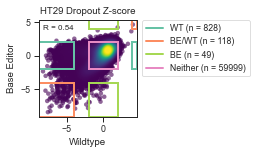

In [15]:
fig, ax = plot_cutoffs('HT29;CP1483;XPR_023;AvgABC;17;Dropout;;z_score', 'HT29;AADW08;RDA077;Dropout;AvgABC;D21;z_score',
            joined_ko_be, small_cutoff, big_cutoff, dropout_hit_summaries)
plt.title('HT29 Dropout Z-score')
plt.xlabel('Wildtype')
plt.ylabel('Base Editor')
fig.savefig('/Users/pdeweird/Documents/BE_clinvar/figures/dropout_zs.svg', dpi = 300, bbox_inches = "tight")

In [16]:
# We then merged the z-scores with annotations from VEP
drop_hits_impact = dropout_hits.merge(impact_annotations, how = 'left', 
                     left_on = 'Construct Barcode', right_on = 'sgRNA')
# REVIEW 5
# If a sgRNA is not in the VEP annotations and it's nota control, then it doesn't make 
# any edits in a non-GC motif. This might be incorrect for a very small number of sgRNAs
drop_hits_impact['Impact'] = drop_hits_impact['Impact'].fillna('No edit')
print(len(drop_hits_impact))

60994


In [17]:
drop_impact = (drop_hits_impact.groupby('type')
               .Impact
               .value_counts()
               .reset_index(name = 'instances'))
drop_impact['n'] = (drop_impact.groupby('type')
                    .instances
                    .transform('sum'))
drop_impact['fraction'] = drop_impact['instances']/drop_impact['n']
drop_impact.sort_values('n', ascending = False)

,type,Impact,instances,n,fraction
12,Neither,LOW,10218,59999,0.170303
13,Neither,No edit,10020,59999,0.167003
17,Neither,Positive control,200,59999,0.003333
16,Neither,Negative control,1325,59999,0.022084
15,Neither,HIGH,5198,59999,0.086635
11,Neither,MODERATE,26023,59999,0.433724
14,Neither,MODIFIER,7015,59999,0.116919
23,WT,Positive control,8,828,0.009662
22,WT,HIGH,40,828,0.048309
21,WT,MODIFIER,45,828,0.054348


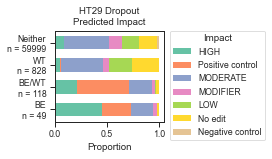

In [18]:
drop_impact['name'] = drop_impact.type + '\nn = ' + drop_impact.n.astype(str)
fig, ax = stacked_bar(drop_impact.sort_values('n', ascending = True), 'name', 'Impact', 'fraction', 
                      hue_categories = ['HIGH', 'Positive control', 'MODERATE', 'MODIFIER', 'LOW', 'No edit','Negative control'], 
                      index_categories = list(drop_impact.sort_values('n', ascending = True).name.unique()),
            colors = sns.color_palette('Set2'), linewidth = 0)
plt.ylabel('')
plt.xlabel('Proportion')
plt.title('HT29 Dropout\nPredicted Impact')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol =1, title = 'Impact')
fig.savefig('/Users/pdeweird/Documents/BE_clinvar/figures/clinvar_overview.svg', 
            bbox_inches = "tight")

In [19]:
# We then merged the z-scores with consequence annotations from VEP
drop_hits_consq = dropout_hits.merge(consequence_annotations, how = 'left', 
                     left_on = 'Construct Barcode', right_on = 'sgRNA')
drop_hits_consq['short_consq'] = drop_hits_consq['short_consq'].fillna('No edit')
print(len(drop_hits_consq))

60994


In [20]:
# keep all consequences with a max fraction > 0.05
keep_consq = ['Positive control', 'missense_variant', 'splice_acceptor_variant',
              'No edit', 'synonymous_variant', 'stop_gained', 'splice_donor_variant']
drop_hits_consq['short_consq'] = [consq if consq in keep_consq else 'Other' for consq in drop_hits_consq['short_consq']]

In [21]:
drop_consequence = (drop_hits_consq.groupby('type')
               .short_consq
               .value_counts()
               .reset_index(name = 'instances'))
drop_consequence['n'] = (drop_consequence.groupby('type')
                    .instances
                    .transform('sum'))
drop_consequence['fraction'] = drop_consequence['instances']/drop_consequence['n']
drop_consequence[drop_consequence.type == 'BE'].sort_values('fraction', ascending = False)
drop_consequence['name'] = drop_consequence.type + '\nn = ' + drop_consequence.n.astype(str)
drop_cosq_order = list(drop_consequence.groupby('short_consq')
                   .agg({'fraction': 'mean'})
                   .sort_values('fraction', ascending = False)
                   .index)
drop_cosq_order.remove('Other')
drop_cosq_order.append('Other')

In [22]:
drop_consequence

,type,short_consq,instances,n,fraction,name
0,BE,splice_acceptor_variant,17,49,0.346939,BE\nn = 49
1,BE,Positive control,14,49,0.285714,BE\nn = 49
2,BE,missense_variant,10,49,0.204082,BE\nn = 49
3,BE,splice_donor_variant,4,49,0.081633,BE\nn = 49
4,BE,Other,2,49,0.040816,BE\nn = 49
5,BE,No edit,1,49,0.020408,BE\nn = 49
6,BE,stop_gained,1,49,0.020408,BE\nn = 49
7,BE/WT,Positive control,59,118,0.500000,BE/WT\nn = 118
8,BE/WT,missense_variant,26,118,0.220339,BE/WT\nn = 118
9,BE/WT,stop_gained,14,118,0.118644,BE/WT\nn = 118


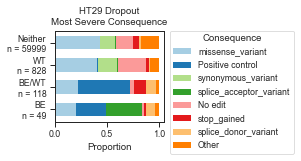

In [23]:
fig, ax = stacked_bar(drop_consequence, 'name', 'short_consq', 'fraction', 
            hue_categories = drop_cosq_order, index_categories = list(drop_impact.sort_values('n', ascending = True).name.unique()),
            colors = sns.color_palette('Paired'), linewidth = 0)
plt.ylabel('')
plt.xlabel('Proportion')
plt.title('HT29 Dropout\nMost Severe Consequence')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol =1, title = 'Consequence')
fig.savefig('/Users/pdeweird/Documents/BE_clinvar/figures/clinvar_do_consq.svg', 
            bbox_inches = "tight")

#### Defining missense hits
To identify gain of function hits, we filtered for guides predicted to introduce missense mutations, which only score in the BE arm

In [24]:
be_mis_drop_hits = (drop_hits_consq.loc[drop_hits_consq.short_consq.isin(['missense_variant']) & 
                                        (drop_hits_consq.type == 'BE'),  
                                        ['Name', 'ClinicalSignificance', 'sgRNA sequence', 'Gene', 'SNP_Position', 
                                         'short_consq', 'HT29;CP1483;XPR_023;AvgABC;17;Dropout;;z_score', 
                                         'HT29;AADW08;RDA077;Dropout;AvgABC;D21;z_score', 
                                         'ClinVar_nonGC_edits', 'nonGC_bystanders']]
                    .reset_index(drop = True))
be_mis_drop_hits['Difference'] = be_mis_drop_hits['HT29;AADW08;RDA077;Dropout;AvgABC;D21;z_score'] - be_mis_drop_hits['HT29;CP1483;XPR_023;AvgABC;17;Dropout;;z_score']

In [25]:
# for each guide, calculate how far into the intron the guide goes
dropout_match_df = get_match_df(be_mis_drop_enst, be_mis_drop_hits)
dropout_matched_hits = be_mis_drop_hits.merge(dropout_match_df, how = 'inner', on = 'sgRNA sequence')
dropout_matched_hits.sort_values('Difference')

,Name,ClinicalSignificance,sgRNA sequence,Gene,SNP_Position,short_consq,HT29;CP1483;XPR_023;AvgABC;17;Dropout;;z_score,HT29;AADW08;RDA077;Dropout;AvgABC;D21;z_score,ClinVar_nonGC_edits,nonGC_bystanders,Difference,match,intronic_nts
4,NM_006087.3(TUBB4A):c.731G>A (p.Gly244Asp);NM_...,Pathogenic,CTGGCCCGGGAAGCGCAGGC,TUBB4A,6495768;6495769,missense_variant,-0.504428,-6.424357,1.0,1.0,-5.919929,CCTGCCTGCGCTTCCCGGGCCAG,0
9,NM_002691.3(POLD1):c.3075G>A (p.Val1025=),Likely benign,ACTCACACACGGCTCCTGTG,POLD1,50417052,missense_variant,0.526721,-4.648841,1.0,2.0,-5.175562,ccccacagGAGCCGTGTGTGAGT,8
5,NM_000552.4(VWF):c.2025G>A (p.Pro675=),Uncertain significance,CATCCGGGTAAGAGAGAGAG,VWF,6052704,missense_variant,0.484609,-4.443924,1.0,1.0,-4.928533,CCGCTCTCTCTCTTACCCGGATG,0
0,NM_001904.3(CTNNB1):c.134C>T (p.Ser45Phe),"Pathogenic/Likely pathogenic, other",GCTCCTTCTCTGAGTGGTAA,CTNNB1,41224646,missense_variant,0.140510,-4.446757,1.0,2.0,-4.587268,GCTCCTTCTCTGAGTGGTAAAGG,0
8,NM_015384.4(NIPBL):c.7330G>A (p.Glu2444Lys),Uncertain significance,GGCTCTTCCTGTGTCTGGTA,NIPBL,37057252,missense_variant,-0.445604,-4.507294,1.0,1.0,-4.061689,CCATACCAGACACAGGAAGAGCC,0
6,NM_002691.3(POLD1):c.2954G>A (p.Arg985Gln);NM_...,Uncertain significance;Likely benign,GTCCCCCCCTGCAGGAGAGG,POLD1,50416610;50416611,missense_variant,-1.477127,-4.943254,2.0,3.0,-3.466127,cctcctctcctgcagGGGGGGAC,15
1,NM_015384.4(NIPBL):c.42G>A (p.Ala14=),Likely benign,AATCCCCGCAAGAGTAGTAA,NIPBL,36953738,missense_variant,-1.259871,-4.536424,1.0,3.0,-3.276553,CCATTACTACTCTTGCGGGGATT,0
7,NM_006231.3(POLE):c.3384G>A (p.Leu1128=),Likely benign,AATCCAGAATCTGCATGTGC,POLE,132657424,missense_variant,-1.896065,-5.111793,1.0,1.0,-3.215728,cctgcacatgcagATTCTGGATT,13
3,NM_007215.3(POLG2):c.544C>T (p.Arg182Trp),Likely pathogenic,CTACGGGAGAACCTTCTTCA,POLG2,64496425,missense_variant,-1.976205,-4.299196,1.0,0.0,-2.322991,CTACGGGAGAACCTTCTTCACGg,1
2,NM_002693.2(POLG):c.2558G>A (p.Arg853Gln);NM_0...,Pathogenic;Likely pathogenic,AGCCCGGCGAGTGATGGTGC,POLG,89321776;89321779,missense_variant,-1.749970,-4.014426,1.0,1.0,-2.264456,CCGGCACCATCACTCGCCGGGCT,0


In [26]:
(dropout_matched_hits[dropout_matched_hits.intronic_nts == 0]
 .drop(['match'], axis = 1)
 .rename({'short_consq': 'Consequence',
          'HT29;CP1483;XPR_023;AvgABC;17;Dropout;;z_score': 'HT29 WT Dropout',
          'HT29;AADW08;RDA077;Dropout;AvgABC;D21;z_score': 'HT29 BE Dropout'},
         axis = 1)
 .sort_values('Difference')
 .to_csv('/Users/pdeweird/Documents/BE_clinvar/Data/enrichment/ClinVar_BE_dropout_missense_sgRNAs.csv', index = False))

## Cisplatin

In [27]:
print('total BE cisplatin hits: ' + str(sum(joined_ko_be['HT29;AADW08;RDA077;Cisplatin;AvgABC;D21;z_score'].abs() > big_cutoff)))

total BE cisplatin hits: 258


In [28]:
cisplatin_hits = get_hit_types('HT29;CP1483;XPR_023;AvgAB;17;Cisplatin;8uM;z_score', 
                             'HT29;AADW08;RDA077;Cisplatin;AvgABC;D21;z_score',
                             joined_ko_be, small_cutoff, big_cutoff)
print('guides which fall into a region: ' + str(len(cisplatin_hits)))

guides which fall into a region: 57664


In [29]:
cisplatin_hit_summaries = (cisplatin_hits
                         .groupby('type')
                         .agg({'Construct Barcode':'count'})
                         .rename({'Construct Barcode': 'n'}, axis = 1)
                         .reset_index())
cisplatin_hit_summaries['name'] = cisplatin_hit_summaries['type'] + ' (n = ' + cisplatin_hit_summaries['n'].astype(str) + ')'
cisplatin_hit_summaries

,type,n,name
0,BE,77,BE (n = 77)
1,BE/WT,113,BE/WT (n = 113)
2,Neither,56421,Neither (n = 56421)
3,WT,1053,WT (n = 1053)


/Users/pdeweird/anaconda3/envs/BE_clinvar/lib/python3.8/site-packages/seaborn/relational.py:918: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  scout = ax.scatter([], [], **kws)
/Users/pdeweird/anaconda3/envs/BE_clinvar/lib/python3.8/site-packages/seaborn/relational.py:955: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  points = ax.scatter(*args, **kws)


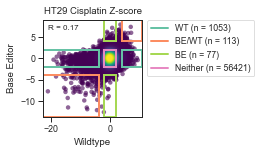

In [30]:
fig, ax = plot_cutoffs('HT29;CP1483;XPR_023;AvgAB;17;Cisplatin;8uM;z_score', 'HT29;AADW08;RDA077;Cisplatin;AvgABC;D21;z_score',
            joined_ko_be, small_cutoff, big_cutoff, cisplatin_hit_summaries)
plt.title('HT29 Cisplatin Z-score')
plt.xlabel('Wildtype')
plt.ylabel('Base Editor')
fig.savefig('/Users/pdeweird/Documents/BE_clinvar/figures/cisplatin_zs.svg', dpi = 300, bbox_inches = "tight")

In [31]:
# We then merged the z-scores with annotations from VEP
cisplatin_hits_impact = cisplatin_hits.merge(impact_annotations, how = 'left', 
                     left_on = 'Construct Barcode', right_on = 'sgRNA')
cisplatin_hits_impact['Impact'] = cisplatin_hits_impact['Impact'].fillna('No edit')
print(len(cisplatin_hits_impact))

57664


In [32]:
cis_impact = (cisplatin_hits_impact.groupby('type')
               .Impact
               .value_counts()
               .reset_index(name = 'instances'))
cis_impact['n'] = (cis_impact.groupby('type')
                    .instances
                    .transform('sum'))
cis_impact['fraction'] = cis_impact['instances']/cis_impact['n']
cis_impact.sort_values('n', ascending = False)

,type,Impact,instances,n,fraction
13,Neither,MODERATE,24310,56421,0.430868
14,Neither,LOW,9558,56421,0.169405
19,Neither,Positive control,280,56421,0.004963
18,Neither,Negative control,1293,56421,0.022917
17,Neither,HIGH,4837,56421,0.085730
16,Neither,MODIFIER,6787,56421,0.120292
15,Neither,No edit,9356,56421,0.165825
25,WT,Positive control,18,1053,0.017094
24,WT,MODIFIER,40,1053,0.037987
23,WT,HIGH,64,1053,0.060779


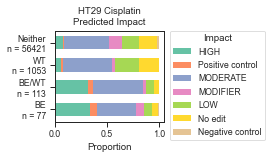

In [33]:
cis_impact['name'] = cis_impact.type + '\nn = ' + cis_impact.n.astype(str)
fig, ax = stacked_bar(cis_impact.sort_values('n', ascending = True), 'name', 'Impact', 'fraction', 
                      hue_categories = ['HIGH', 'Positive control', 'MODERATE', 'MODIFIER', 'LOW', 'No edit','Negative control'], 
                      index_categories = list(cis_impact.sort_values('n', ascending = True).name.unique()),
            colors = sns.color_palette('Set2'), linewidth = 0)
plt.ylabel('')
plt.xlabel('Proportion')
plt.title('HT29 Cisplatin\nPredicted Impact')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol =1, title = 'Impact')
fig.savefig('/Users/pdeweird/Documents/BE_clinvar/figures/clinvar_overview_cis.svg', 
            bbox_inches = "tight")

In [34]:
# We then merged the z-scores with consequence annotations from VEP
cis_hits_consq = cisplatin_hits.merge(consequence_annotations, how = 'left', 
                     left_on = 'Construct Barcode', right_on = 'sgRNA')
cis_hits_consq['short_consq'] = cis_hits_consq['short_consq'].fillna('No edit')
print(len(drop_hits_consq))

60994


In [35]:
# keep all consequences with a max fraction > 0.05
keep_consq = ['Positive control', 'missense_variant', 'splice_acceptor_variant',
              'No edit', 'synonymous_variant', 'stop_gained', 'splice_donor_variant']
cis_hits_consq['short_consq'] = [consq if consq in keep_consq else 'Other' for consq in cis_hits_consq['short_consq']]

In [36]:
cis_consequence = (cis_hits_consq.groupby('type')
               .short_consq
               .value_counts()
               .reset_index(name = 'instances'))
cis_consequence['n'] = (cis_consequence.groupby('type')
                    .instances
                    .transform('sum'))
cis_consequence['fraction'] = cis_consequence['instances']/cis_consequence['n']
cis_consequence[cis_consequence.type == 'BE'].sort_values('fraction', ascending = False)
cis_consequence['name'] = cis_consequence.type + '\nn = ' + cis_consequence.n.astype(str)

In [37]:
cis_consequence

,type,short_consq,instances,n,fraction,name
0,BE,missense_variant,29,77,0.376623,BE\nn = 77
1,BE,stop_gained,12,77,0.155844,BE\nn = 77
2,BE,splice_acceptor_variant,11,77,0.142857,BE\nn = 77
3,BE,Other,8,77,0.103896,BE\nn = 77
4,BE,Positive control,5,77,0.064935,BE\nn = 77
5,BE,synonymous_variant,5,77,0.064935,BE\nn = 77
6,BE,No edit,4,77,0.051948,BE\nn = 77
7,BE,splice_donor_variant,3,77,0.038961,BE\nn = 77
8,BE/WT,missense_variant,54,113,0.477876,BE/WT\nn = 113
9,BE/WT,stop_gained,30,113,0.265487,BE/WT\nn = 113


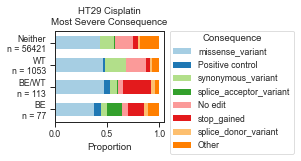

In [38]:
fig, ax = stacked_bar(cis_consequence, 'name', 'short_consq', 'fraction', 
            hue_categories = drop_cosq_order, index_categories = list(cis_consequence.sort_values('n', ascending = True).name.unique()),
            colors = sns.color_palette('Paired'), linewidth = 0)
plt.ylabel('')
plt.xlabel('Proportion')
plt.title('HT29 Cisplatin\nMost Severe Consequence')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol =1, title = 'Consequence')
fig.savefig('/Users/pdeweird/Documents/BE_clinvar/figures/clinvar_cis_consq.svg', 
            bbox_inches = "tight")

#### Defining missense hits
To identify gain of function hits, we filtered for guides predicted to introduce missense mutations, which only score in the BE arm

In [39]:
be_mis_cis_hits = (cis_hits_consq.loc[cis_hits_consq.short_consq.isin(['missense_variant']) & 
                                        (cis_hits_consq.type == 'BE'),  
                                        ['Name', 'ClinicalSignificance', 'sgRNA sequence', 'Gene', 'SNP_Position', 
                                         'short_consq', 'HT29;CP1483;XPR_023;AvgAB;17;Cisplatin;8uM;z_score', 
                                         'HT29;AADW08;RDA077;Cisplatin;AvgABC;D21;z_score', 
                                         'ClinVar_nonGC_edits', 'nonGC_bystanders']]
                    .reset_index(drop = True))
be_mis_cis_hits['Difference'] = be_mis_cis_hits['HT29;AADW08;RDA077;Cisplatin;AvgABC;D21;z_score'] - be_mis_cis_hits['HT29;CP1483;XPR_023;AvgAB;17;Cisplatin;8uM;z_score']

In [40]:
cis_match_df = get_match_df(be_mis_cis_enst, be_mis_cis_hits)
cis_matched_hits = be_mis_cis_hits.merge(cis_match_df, how = 'inner', on = 'sgRNA sequence')
cis_matched_hits.sort_values('Difference')

,Name,ClinicalSignificance,sgRNA sequence,Gene,SNP_Position,short_consq,HT29;CP1483;XPR_023;AvgAB;17;Cisplatin;8uM;z_score,HT29;AADW08;RDA077;Cisplatin;AvgABC;D21;z_score,ClinVar_nonGC_edits,nonGC_bystanders,Difference,match,intronic_nts
5,NM_000465.3(BARD1):c.152C>T (p.Ser51Leu),Uncertain significance,GCTGCTCGCGTTGGTAAAGA,BARD1,214809418,missense_variant,-0.991682,-9.290656,1.0,0.0,-8.298974,GCTGCTCGCGTTGgtaaagacgg,10
11,NM_005957.4(MTHFR):c.*2801C>T,Uncertain significance,GTTCCCTGCACCCTGGAAAG,MTHFR,11787879,missense_variant,1.698504,-4.848182,1.0,2.0,-6.546686,GTTCCCTGCACCCTGGAAAGGGG,0
25,NM_032957.4(RTEL1):c.1620C>T (p.Val540=),Benign,GTCGTCCCCAGAGGCCCCGA,RTEL1,63688003,missense_variant,-0.762545,-7.250897,1.0,2.0,-6.488352,GTCGTCCCCAGAGGCCCCGATGG,0
9,NM_002691.3(POLD1):c.2163G>A (p.Thr721=),Likely benign,AACCCCGTGACGCTCTGTCG,POLD1,50413434,missense_variant,1.851463,-4.584133,1.0,2.0,-6.435596,ccccgacagAGCGTCACGGGGTT,9
0,NM_006218.3(PIK3CA):c.1633G>A (p.Glu545Lys),Pathogenic/Likely pathogenic,TGCTCAGTGATTTCAGAGAG,PIK3CA,179218303,missense_variant,1.294308,-4.810752,1.0,0.0,-6.105059,CCTCTCTCTGAAATCACTGAGCA,0
8,NM_006231.3(POLE):c.4660G>A (p.Glu1554Lys);NM_...,Uncertain significance,GAACTTCGAAGGTGTGTTTG,POLE,132642888;132642885,missense_variant,1.856813,-4.009121,2.0,0.0,-5.865933,CCCCAAACACACCTTCGAAGTTC,0
15,NM_000481.3(AMT):c.350C>T (p.Ser117Leu),Uncertain significance,ACTGTCGCTGTTTACCAACG,AMT,49420332,missense_variant,0.843043,-4.243836,1.0,0.0,-5.086879,ACTGTCGCTGTTTACCAACGAGG,0
27,NM_021922.2(FANCE):c.1111C>T (p.Arg371Trp),Uncertain significance,GGACGGGTAGGTGTATTGGG,FANCE,35458438,missense_variant,-1.912420,-6.625016,1.0,0.0,-4.712596,GGACGGgtaggtgtattgggagg,17
13,NM_000465.3(BARD1):c.1497C>T (p.His499=),Likely benign,CTTCACGATGCAGCCAAGAA,BARD1,214767553,missense_variant,0.355483,-4.227903,1.0,1.0,-4.583386,CTTCACGATGCAGCCAAGAATGG,0
26,NM_006767.3(LZTR1):c.1164G>A (p.Arg388=),Likely benign,AGAGCCTCCCACTGGGCAGC,LZTR1,20992808,missense_variant,-0.108392,-4.581214,0.0,2.0,-4.472822,ccagCTGCCCAGTGGGAGGCTCT,4


In [41]:
(cis_matched_hits[cis_matched_hits.intronic_nts == 0]
 .drop(['match'], axis = 1)
 .rename({'short_consq': 'Consequence', 
                              'HT29;CP1483;XPR_023;AvgAB;17;Cisplatin;8uM;z_score': 'HT29 WT Cisplatin', 
                              'HT29;AADW08;RDA077;Cisplatin;AvgABC;D21;z_score': 'HT29 BE Cisplatin'},
                             axis = 1)
 .sort_values('Difference')
 .to_csv('/Users/pdeweird/Documents/BE_clinvar/Data/enrichment/ClinVar_BE_cisplatin_missense_sgRNAs.csv',index = False))